In [1]:
# The purpose of this notebook is to create a pre-recovered mRNN. Recovery is obviously tied to a particular lesion.

%load_ext autoreload
%autoreload 2

import matplotlib
import matplotlib.pyplot as plt

import os
import random

import numpy as np
import torch
from torch.optim import AdamW
import scipy.io

from experiment import lesion
from experiment import mRNN
from experiment import michaels_load
from experiment import stim
from experiment import utils

# Relative to the cwd. This is where we will store the recovered model
OUT_DIR = "experiment/recovered"

CUDA = torch.device(3)
#CUDA = None


In [2]:
mike = mRNN.MichaelsRNN(init_data_path=michaels_load.get_default_path(),
                       cuda=CUDA)

In [3]:
# Get the Michaels session data
dataset = mRNN.MichaelsDataset(michaels_load.get_default_path(),
    cuda=CUDA, with_label=True)

# Dataset items are:
#   (michaels network input, trial end indicator, trial len (scalar),
#    target output, class label)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=len(dataset))

In [4]:
# The whole dataset
all_data = next(iter(dataloader))

din = all_data[0]
dout = all_data[-2]
trial_end = all_data[1]

batch_size = din.shape[0]
trial_len = din.shape[1]
out_dim = dout.shape[-1]

dout = utils.trunc_to_trial_end(dout, trial_end)


# Batch idx, time, feature
print("Input shape:", din.shape)

# Batch idx, time, muscle idx
print("Output shape:", dout.shape)

Input shape: torch.Size([502, 341, 21])
Output shape: torch.Size([502, 341, 50])


In [5]:
# Ground truth vs. un-lesioned network. We use this to measure how much recovery we've seen.

preds = torch.empty(dout.shape)
if CUDA:
    preds = preds.cuda(CUDA)

mike.reset()

for tidx in range(trial_len):
    mike_in = din[:, tidx, :].T
    mike_out = mike(mike_in)
    preds[:, tidx, :] = mike_out

healthy_preds = utils.trunc_to_trial_end(preds, trial_end)

healthy_loss = torch.nn.MSELoss()(healthy_preds, dout)
print("Healthy loss:", healthy_loss.item())


Healthy loss: 0.0005658188601955771


In [6]:
# Now set up our lesion.  If we want to try different lesions, change the lesion def here.
connections = [
    # No F5->M1
    (1, 2, 0, 1),
    # No M1->F5
    (0, 1, 1, 2),
]
mike.reset()
lesion_instance = lesion.LesionConnectionsByIdxs(100, connections, cuda=CUDA)
mike.set_lesion(lesion_instance)

In [7]:
# Ground truth vs. lesioned network.

preds = torch.empty(dout.shape)
if CUDA:
    preds = preds.cuda(CUDA)

mike.reset()

for tidx in range(trial_len):
    mike_in = din[:, tidx, :].T
    mike_out = mike(mike_in)
    preds[:, tidx, :] = mike_out

lesioned_preds = utils.trunc_to_trial_end(preds, trial_end)

lesioned_loss = torch.nn.MSELoss()(lesioned_preds, dout)
print("Lesioned loss:", lesioned_loss.item())


Lesioned loss: 0.0207260400056839


In [8]:
# Now we do some recovery.
model_out_path = os.path.join(OUT_DIR, "recovered_mrnn_%s.model" % str(lesion_instance))
print("Model will be written to:", model_out_path)

mike.reset()
mike_opt = AdamW(mike.parameters(), lr=1e-4)

cur_loss = lesioned_loss
eidx = 0

# We will presumably never hit this condition?
while cur_loss > healthy_loss:
    mike_opt.zero_grad()
    
    if (eidx % 100) == 0:
        torch.save(mike.state_dict(), model_out_path)
        
    preds = torch.empty(dout.shape)
    if CUDA:
        preds = preds.cuda(CUDA)

    mike.reset()

    for tidx in range(trial_len):
        mike_in = din[:, tidx, :].T
        mike_out = mike(mike_in)
        preds[:, tidx, :] = mike_out
    preds = utils.trunc_to_trial_end(preds, trial_end)
    
    lesioned_loss = torch.nn.MSELoss()(preds, dout)
    lesioned_loss.backward()
    
    # This ensures we don't break some of the modularity invariants, basically.
    if lesion_instance.application == "connection":
        mike.set_connection_coadap_grads()
    else:
        mike.set_end_to_end_coadap_grads()
    mike_opt.step()
    
    cur_loss = lesioned_loss
    
    print("Loss: %0.5f" % (cur_loss.item()))

Model will be written to: experiment/recovered/recovered_mrnn_connectionsIdxs[(1, 2, 0, 1), (0, 1, 1, 2)].model
Loss: 0.02073
Loss: 0.01967
Loss: 0.01866
Loss: 0.01767
Loss: 0.01671
Loss: 0.01579
Loss: 0.01492
Loss: 0.01407
Loss: 0.01326
Loss: 0.01250
Loss: 0.01178
Loss: 0.01110
Loss: 0.01047
Loss: 0.00988
Loss: 0.00935
Loss: 0.00885
Loss: 0.00839
Loss: 0.00798
Loss: 0.00760
Loss: 0.00726
Loss: 0.00695
Loss: 0.00667
Loss: 0.00642
Loss: 0.00620
Loss: 0.00600
Loss: 0.00583
Loss: 0.00567
Loss: 0.00554
Loss: 0.00541
Loss: 0.00530
Loss: 0.00521
Loss: 0.00514
Loss: 0.00508
Loss: 0.00503
Loss: 0.00499
Loss: 0.00495
Loss: 0.00491
Loss: 0.00487
Loss: 0.00483
Loss: 0.00480
Loss: 0.00476
Loss: 0.00472
Loss: 0.00469
Loss: 0.00465
Loss: 0.00462
Loss: 0.00459
Loss: 0.00456
Loss: 0.00454
Loss: 0.00451
Loss: 0.00448
Loss: 0.00446
Loss: 0.00444
Loss: 0.00441
Loss: 0.00439
Loss: 0.00437
Loss: 0.00435
Loss: 0.00433
Loss: 0.00432
Loss: 0.00430
Loss: 0.00429
Loss: 0.00428
Loss: 0.00426
Loss: 0.00425
Loss: 

Loss: 0.00385
Loss: 0.00385
Loss: 0.00385
Loss: 0.00385
Loss: 0.00385
Loss: 0.00385
Loss: 0.00385
Loss: 0.00385
Loss: 0.00385
Loss: 0.00385
Loss: 0.00385
Loss: 0.00385
Loss: 0.00385
Loss: 0.00385
Loss: 0.00385
Loss: 0.00385
Loss: 0.00385
Loss: 0.00385
Loss: 0.00385
Loss: 0.00385
Loss: 0.00385
Loss: 0.00385
Loss: 0.00385
Loss: 0.00385
Loss: 0.00385
Loss: 0.00385
Loss: 0.00385
Loss: 0.00385
Loss: 0.00385
Loss: 0.00385
Loss: 0.00385
Loss: 0.00385
Loss: 0.00385
Loss: 0.00385
Loss: 0.00385
Loss: 0.00385
Loss: 0.00385
Loss: 0.00385
Loss: 0.00385
Loss: 0.00385
Loss: 0.00385
Loss: 0.00385
Loss: 0.00385
Loss: 0.00385
Loss: 0.00385
Loss: 0.00385
Loss: 0.00385
Loss: 0.00385
Loss: 0.00385
Loss: 0.00385
Loss: 0.00385
Loss: 0.00385
Loss: 0.00385
Loss: 0.00385
Loss: 0.00385
Loss: 0.00385
Loss: 0.00385
Loss: 0.00385
Loss: 0.00385
Loss: 0.00385
Loss: 0.00385
Loss: 0.00385
Loss: 0.00385
Loss: 0.00385
Loss: 0.00385
Loss: 0.00385
Loss: 0.00385
Loss: 0.00385
Loss: 0.00385
Loss: 0.00385
Loss: 0.00385
Loss: 

KeyboardInterrupt: 

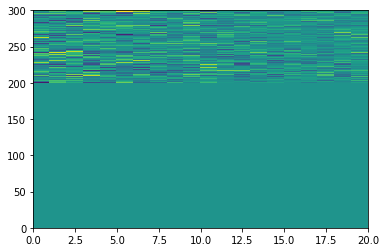

In [9]:
# Graph before/after to make sure we are doing what we think we are
mike_orig = mRNN.MichaelsRNN(init_data_path=michaels_load.get_default_path(),
                       cuda=CUDA)

I_diff = mike_orig.I - mike.I
J_diff = mike_orig.J - mike.J
S_diff = mike_orig.S - mike.S
B_diff = mike_orig.B - mike.B

# No learning can get back here because of the lesion; this should be blank
plt.pcolormesh(I_diff.cpu().detach().numpy())
plt.show()

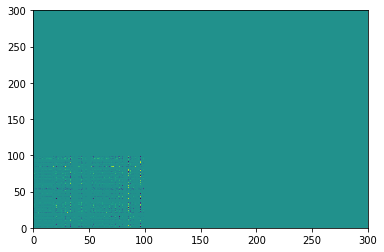

In [10]:
# M1 (low index) changes only
plt.pcolormesh(J_diff.cpu().detach().numpy())
plt.show()

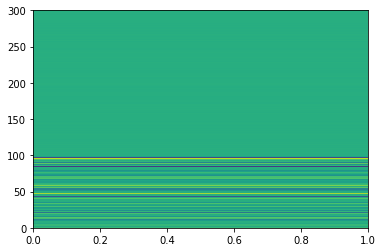

In [11]:
# M1 (low index) changes only
plt.pcolormesh(S_diff.cpu().detach().numpy())
plt.show()

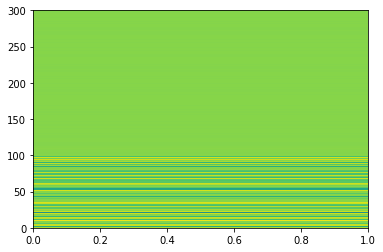

In [12]:
# M1 (low index) changes only
plt.pcolormesh(B_diff.cpu().detach().numpy())
plt.show()

In [14]:
print(B_diff[200:,:])

tensor([[-6.7793e-05],
        [ 5.2728e-05],
        [ 3.3896e-05],
        [ 3.7663e-06],
        [-6.1734e-13],
        [ 5.1786e-06],
        [-4.1429e-05],
        [ 4.2371e-06],
        [ 8.2387e-07],
        [-4.1429e-05],
        [ 4.8961e-05],
        [-4.7078e-06],
        [ 9.7923e-05],
        [ 6.4027e-05],
        [ 8.4741e-06],
        [-5.6494e-05],
        [-7.5325e-06],
        [-3.7663e-05],
        [ 1.4124e-05],
        [ 9.4157e-06],
        [-3.0130e-05],
        [-4.1429e-05],
        [-3.7663e-05],
        [-6.0260e-05],
        [ 2.3539e-06],
        [-6.7793e-05],
        [-2.8247e-06],
        [ 2.8247e-05],
        [ 4.8961e-05],
        [-1.8831e-05],
        [ 2.2598e-05],
        [ 1.8831e-05],
        [ 1.6948e-05],
        [ 4.2371e-06],
        [ 3.8584e-14],
        [ 9.7923e-05],
        [-8.2858e-05],
        [-1.8831e-05],
        [-7.0618e-06],
        [-4.1429e-05],
        [-7.5325e-05],
        [ 4.5195e-05],
        [ 1.8831e-05],
        [ 2